In [1]:
#import astropy fits
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy import units as u

IMPORTING THE DATA

In [4]:
catalog_voss_class="VOSS_classifications.fits"
catalog_AllWise="AllWISE.fits"
catalog_Gaia_EDR3="Gaia_EDR3.fits"
catalog_panstarrs="PanSTARRS1DR2.fits"
catalog_Gaia_EDR3_subset="subset_Gaia_EDR3.fits"


df_voss=pd.DataFrame()
df_AllWise=pd.DataFrame()
df_Gaia_EDR3=pd.DataFrame()
df_panstarrs=pd.DataFrame()
df_subset=pd.DataFrame()

#why are some columns 2D arrays? I just reshape them to 1D.

#reading the catalogs and saving them to dataframes

def read_fits(catalog,df,removestrings=True):
    """ Reads a fits catalog and saves it to a dataframe. If removestrings is 
    True, it removes columns with string data type. """
    with fits.open(catalog) as data:
        columns=(data[1].columns)
        dimension=data[1].data[columns[0].name].shape[0]
        for c in columns:
            if data[1].data[c.name].shape==(dimension, 1):
                datacol=data[1].data[c.name][:,0]
            else:datacol=data[1].data[c.name]
            if removestrings and datacol.dtype.kind=='U': 
                print("removed ",c.name)
                continue
            elif datacol.dtype.kind=='U': df[c.name]=np.asarray(datacol)
            else:df[c.name]=np.asarray(datacol).byteswap().newbyteorder('<')
    return df

df_voss=read_fits(catalog_voss_class,df_voss,removestrings=False)
df_AllWise=read_fits(catalog_AllWise,df_AllWise)
df_Gaia_EDR3=read_fits(catalog_Gaia_EDR3,df_Gaia_EDR3)
df_panstarrs=read_fits(catalog_panstarrs,df_panstarrs)
df_subset=read_fits(catalog_Gaia_EDR3_subset,df_subset)





removed  source_id
removed  var_flg
removed  objName


### Crossmatching

 

In [5]:
def crossmatch(df1,df2,ra_key1="ra",dec_key1="dec",ra_key2="ra",dec_key2="dec",Nnearest=1):
    """finds the nearest neighbour (regardless of the distance) and returns df1 indeces of df2 counterparts."""
    cat1 = SkyCoord(ra=df1[ra_key1].to_numpy()*u.degree, dec=df1[dec_key1].to_numpy()*u.degree)
    cat2=SkyCoord(ra=df2[ra_key2].to_numpy()*u.degree, dec=df2[dec_key2].to_numpy()*u.degree)
    idx, d2d, d3d = cat1.match_to_catalog_sky(cat2,nthneighbor=Nnearest)
    return idx,d2d,d3d

def combine_data_frames(dfvoss,df,ra_key1="RAd",dec_key1="DECd",ra_key2="ra",dec_key2="dec",
    max_sep=np.inf,df_columns=["ra","dec"], check_second_neighbour=True,remove_doubles=True,remove_doubles_otherway=True):
    """crossmatches the two catalogs and applies additional selection criteria. All sources with closest neighbours further than max_sep are removed.
    If check_second_neighbour is True, all sources with second closest neighbour closer than max_sep are removed.
    If remove_doubles is True, all df sources that appear more than once in dfvoss are removed.
    If remove_doubles_otherway is True, all dfvoss sources that appear more than once in df are removed."""

    idx,d2d,_=crossmatch(dfvoss,df,ra_key1,dec_key1,ra_key2,dec_key2)

    dfvoss=dfvoss.assign(idx_temp=idx)
    voss_finalmask=np.full(len(dfvoss),True)
    #remove those with no matches
    voss_finalmask=d2d<max_sep
    print("distance cut: removed",len(voss_finalmask)-np.sum(voss_finalmask),"sources ({:.3f}) %".format((len(voss_finalmask)-np.sum(voss_finalmask))/len(voss_finalmask)*100))
    currently_removed=len(voss_finalmask)-np.sum(voss_finalmask)

    #check if the next nearest neighbour is closer than maxsep
    if check_second_neighbour:
        _,d2d_2,_=crossmatch(dfvoss,df,ra_key1,dec_key1,ra_key2,dec_key2,Nnearest=2)
        voss_finalmask*=d2d_2>max_sep  
        print("second neighbour cut: removed",len(voss_finalmask)-np.sum(voss_finalmask)-currently_removed,"sources ({:.3f}) %".format((len(voss_finalmask)-np.sum(voss_finalmask)-currently_removed)/len(voss_finalmask)*100))
        currently_removed=len(voss_finalmask)-np.sum(voss_finalmask)
        
    #remove duplicates from dfvoss
    if remove_doubles:
        #find which idx appear more than once
        unique_inxs,counts=np.unique(idx,return_counts=True)
        inxs=unique_inxs[counts>1]
        for i in range(len(voss_finalmask)):
            if idx[i] in inxs: voss_finalmask[i]=False
        print("doubles cut: removed",len(voss_finalmask)-np.sum(voss_finalmask)-currently_removed,"sources ({:.3f}) %".format((len(voss_finalmask)-np.sum(voss_finalmask)-currently_removed)/len(voss_finalmask)*100))
        currently_removed=len(voss_finalmask)-np.sum(voss_finalmask)

    if remove_doubles_otherway:
        #find matches on already narrowed down dfvoss
        inxs_3,d2d_3,_=crossmatch(df,dfvoss,ra_key2,dec_key2,ra_key1,dec_key1)
        #leave only close matches
        inxs_3=inxs_3[d2d_3<max_sep]
        #find indeces of dfvoss that appear more than once
        unique_inxs_3,counts=np.unique(inxs_3,return_counts=True)
        inxs_3=unique_inxs_3[counts>1]
        #remove the line number 3 from voss
        for i in range(len(voss_finalmask)):
            if i in inxs_3: voss_finalmask[i]=False
        print("doubles other way cut: removed",len(voss_finalmask)-np.sum(voss_finalmask)-currently_removed,"sources ({:.3f}) %".format((len(voss_finalmask)-np.sum(voss_finalmask)-currently_removed)/len(voss_finalmask)*100))
        currently_removed=len(voss_finalmask)-np.sum(voss_finalmask)


    df=df[df_columns]
    df=df.assign(idx_temp=np.arange(len(df)))

    #masked indeces
    masked_indeces=dfvoss.idx_temp[voss_finalmask]

    #remove lines of df where idx_temp is not in masked_indeces
    df=df[df.idx_temp.isin(masked_indeces)]

    df=pd.merge(dfvoss,df,on="idx_temp",how="left")

    df=df.drop(columns=["idx_temp"])
    return df


In [6]:
print("AllWise")
dfc=combine_data_frames(df_voss,df_AllWise,max_sep=0.75*u.arcsec,df_columns=["w1mpro","w2mpro","w3mpro","w4mpro"])
print("Gaia")
dfc=combine_data_frames(dfc,df_Gaia_EDR3,max_sep=0.75*u.arcsec,df_columns=["phot_g_mean_mag","phot_bp_mean_mag","phot_rp_mean_mag","parallax","parallax_error","pmra","pmdec","pmra_error","pmdec_error"])
print("PanSTARRS")
dfc=combine_data_frames(dfc,df_panstarrs,max_sep=0.75*u.arcsec,ra_key2="raStack",dec_key2="decStack",df_columns=["gPSFMag","rPSFMag","iPSFMag","zPSFMag","yPSFMag"])

AllWise
distance cut: removed 487372 sources (17.343) %
second neighbour cut: removed 0 sources (0.000) %
doubles cut: removed 168563 sources (5.998) %
doubles other way cut: removed 0 sources (0.000) %
Gaia
distance cut: removed 5631 sources (0.200) %
second neighbour cut: removed 1 sources (0.000) %
doubles cut: removed 2127 sources (0.076) %
doubles other way cut: removed 0 sources (0.000) %
PanSTARRS
distance cut: removed 455 sources (0.016) %
second neighbour cut: removed 0 sources (0.000) %
doubles cut: removed 0 sources (0.000) %
doubles other way cut: removed 0 sources (0.000) %


 Marking stars

In [7]:
#add potential star flag column with zeros
dfc=dfc.assign(potential_star=np.zeros(len(dfc),dtype=int))

#or selection of stars
starmask=np.array(abs(dfc.parallax/dfc.parallax_error)>3) | (np.array(abs(dfc.pmra/dfc.pmra_error)>3) | np.array(abs(dfc.pmdec/dfc.pmdec_error)>3))
starmask_conservative=np.array(abs(dfc.parallax/dfc.parallax_error>3)) | (np.array(abs(dfc.pmra/dfc.pmra_error)>3) | np.array(abs(dfc.pmdec/dfc.pmdec_error)>3))




dfc.loc[starmask,"potential_star"]=1
print("number of potential stars: ",len(dfc[starmask]))

#check istances where potential_star==1 but objtype is not '         '
spurious_mask=(dfc.potential_star==1) & (dfc.objtype!="         ")
print("number of potential stars with objtype not empty: ",np.sum(spurious_mask))
reliable_star_mask=(dfc.potential_star==1) & (dfc.objtype=="         ")
dfc.objtype[reliable_star_mask]="star"


print("aaa",np.unique(dfc.objtype[spurious_mask],return_counts=True))

#create the spurious flag
dfc=dfc.assign(spurious_label=np.zeros(len(dfc),dtype=int))
dfc.loc[spurious_mask,"spurious_label"]=1

#remove potential_star column
dfc=dfc.drop(columns=["potential_star"])


number of potential stars:  1031371
number of potential stars with objtype not empty:  17562


/Users/gregorrih/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


aaa (array(['BLLac    ', 'EmLines  ', 'Extended?', 'Galaxy   ', 'QSO      ',
       'Type2    '], dtype=object), array([    6,     3, 16633,   398,   489,    33]))


In [ ]:
print("a")

In [101]:
print(409/np.sum(dfc.objtype=='QSO      '))

0.023221484131039572


In [84]:
print(710129/len(dfc))

0.3100480094167616


In [9]:
#save dfc
dfc.to_csv("GR_theBigtable.fits")

Some visualisations

In [150]:
idx_allwise, d2d_allwise, d3d_allwise = crossmatch(df_voss,df_AllWise,ra_key2="ra",dec_key2="dec",ra_key1="RAd",dec_key1="DECd")

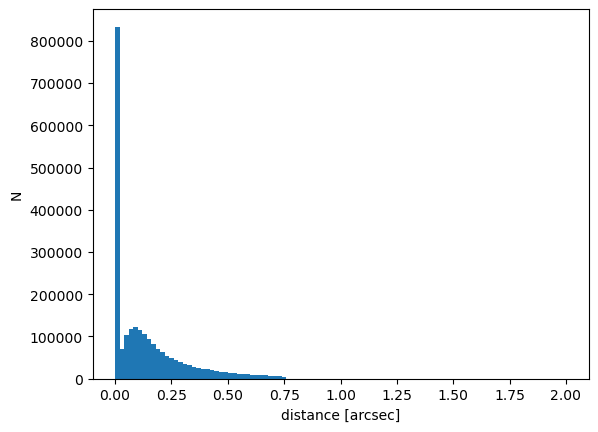

In [152]:
plt.hist(d2d_allwise.to(u.arcsec),bins=100,range=(0,2))
#plt.yscale("log")
plt.xlabel("distance [arcsec]")
plt.ylabel("N")
plt.savefig("hist_allwise.png")

In [90]:
#same for pansstarrs
idx_panstarrs, d2d_panstarrs, d3d_panstarrs = crossmatch(df_voss,df_panstarrs,ra_key2="raStack",dec_key2="decStack",ra_key1="RAd",dec_key1="DECd")

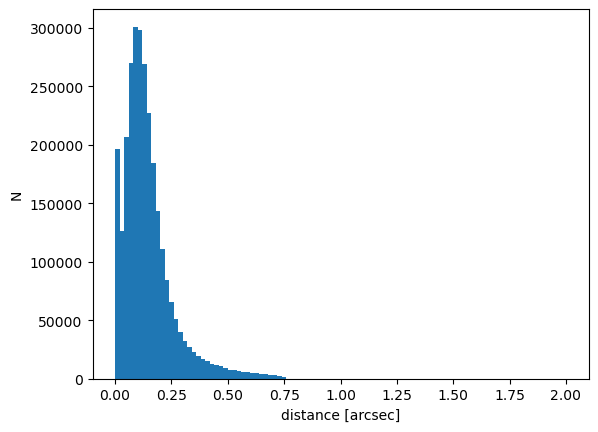

In [94]:
plt.hist(d2d_panstarrs.to(u.arcsec),bins=100,range=(0,2))
#plt.yscale("log")
plt.xlabel("distance [arcsec]")
plt.ylabel("N")
plt.savefig("hist_panstarrs.png")


In [153]:
#same for gaia
idx_gaia, d2d_gaia, d3d_gaia = crossmatch(df_voss,df_Gaia_EDR3,ra_key2="ra",dec_key2="dec",ra_key1="RAd",dec_key1="DECd")

(0.0, 200000.0)

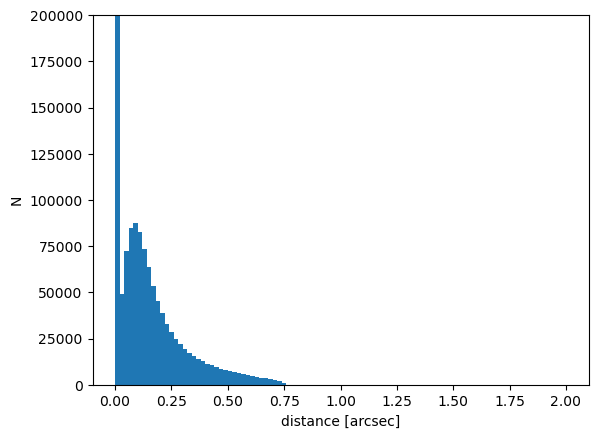

In [154]:
plt.hist(d2d_gaia.to(u.arcsec),bins=100,range=(0,2))
#plt.yscale("log")
plt.xlabel("distance [arcsec]")
plt.ylabel("N")
plt.savefig("hist_gaia.png")
plt.ylim(0,0.2e6)
